# Hypothesis and Inference from scratch

In [5]:
from __future__ import division
from probability import normal_cdf, inverse_normal_cdf
import math, random

A binomial random variable is a specific type of discrete random variable that counts how often a particular event occurs in a fixed number of tries or trials.
    
    Notation: 
        binomial(n, p)
            n = number of trials
            p = probability event of interest occurs on any one trial

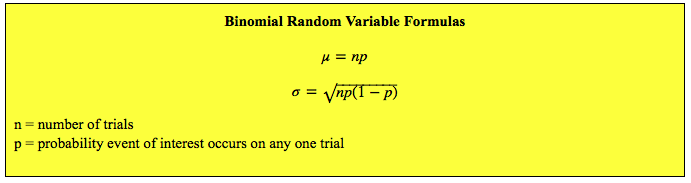

In [1]:
# test for binomial(n, p) random variable
from IPython.display import Image
Image(filename='/Users/annalie/Dev/data-science-from-scratch/binomial-random-variable.png')

In [23]:
# binomial random variable formula
def normal_approximation_to_binomial(n, p):
    """finds mu and sigma corresponding to a Binomial(n, p)"""
    mu = n * p
    sigma = math.sqrt(n * p * (1 - p))
    return mu, sigma

# example: n = 1000 and p = 0.5
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
print "mean: ", mu_0
print "sigma: ", sigma_0

mean:  500.0
sigma:  15.8113883008


    Whenever a random variable follows a normal distribution, we can use normal_cdf to figure out the prbablity that its realized value lies within a particular interval.

In [8]:
# the normal cdf _is_ the probability the variable is below a threshold
normal_probability_below = normal_cdf

In [9]:
# it's above the threshold if it's not below the threshold
def normal_probability_above(lo, mu=0, sigma=1):
    return 1 - normal_cdf(lo, mu, sigma)

In [10]:
# it's between if it's less than hi, but not less than lo
def normal_probability_between(lo, hi, mu=0, sigma=1):
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)

In [11]:
# it's outside the threshold if it's not between
def normal_probability_outside(lo, hi, mu=0, sigma=1):
    return 1- normal_probability_between(lo, hi, mu, sigma)

        We can also use normal_cdf to figure out the interval values for a certain level of likelihood

In [12]:
# find the upper bound value
def normal_upper_bound(probability, mu=0, sigma=1):
    """returns the z for which P(Z <= z) = probability"""
    return inverse_normal_cdf(probability, mu, sigma)

normal_upper_bound(0.7, mu=0, sigma=1)

0.5243968963623047

In [16]:
# find the lower bound value
def normal_lower_bound(probability, mu=0, sigma=1):
    """returns the z for which P(Z >= z) = probability"""
    return inverse_normal_cdf(1 - probability, mu, sigma)

normal_lower_bound(0.95, mu=0, sigma=1)

-1.6448497772216797

In [19]:
# two sided bounds
def normal_two_sided_bounds(probability, mu=0, sigma=1):
    """returns the symmetric (about the mean) bounds 
    that contain the specified probability"""
    tail_probability = (1 - probability) / 2
    
    # upper bound should have tail_probability above it
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)

    # lower bound should have tail_probability below it
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)

    return lower_bound, upper_bound

normal_two_sided_bounds(0.90, mu=0, sigma=1)

(-1.6448497772216797, 1.6448497772216797)

# Hypothesis testing

In [25]:
# n = 1000, p = 0.5
# H0 = 0 for a 5% significane test

mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)

normal_two_sided_bounds(0.95, mu_0, sigma_0)

(469.01026640487555, 530.9897335951244)

    calculate the power of a test, which is the probability of not making a type 2 error, in which we fail to reject H0 even though it's false.

In [28]:
# 2-sided test with 95% bounds based on assumption p = 0.5
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)

In [30]:
# actual mu and sigma based on p = 0.55
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)
print mu_1
print sigma_1

550.0
15.7321327226


In [35]:
# a type 2 error means we fail to reject the null hypothesis which will happen when X is still in our original interval
type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)
power = 1 - type_2_probability

# for example:
type_2_probability = normal_probability_between(469, 530, mu_1, sigma_1)
power = 1 - type_2_probability
print "power: ", power

power:  0.898186217604


In [38]:
# 1-sided test for a 5% significance test (5% is now right of the upper bound)
hi = normal_upper_bound(0.95, mu_0, sigma_0)
print "hi: ", hi

# type 2 error:
type_2_probability = normal_probability_below(526, mu_1, sigma_1)
power = 1 - type_2_probability
print "power: ", power

# this is a more powerful test, since it no longer rejects H0 when X is below the lower bound
# and H0 is rejected when X is between 526 and 531

hi:  526.007358524
power:  0.936437785529


    Instead of working with interval bounderies, we can compute the probability that we would see a value that does not lie between the interval values.

In [43]:
# compute 2-sided test p-value
def two_sided_p_value(x, mu=0, sigma=1):
    if x >= mu:
        # if x is greater than the mean, the tail is above x
        return 2 * normal_probability_above(x, mu, sigma)
    else:
        # if x is less than the mean, the tail is below x
        return 2 * normal_probability_below(x, mu, sigma)
    
# for example if we counter 535 times a certain value instead of 530:
print two_sided_p_value(535, mu_0, sigma_0)
print "reject H0"

0.0268566955075
reject H0


# Testing whether two means differ

In [44]:
# N is targeted number of people and n is number of people that responds

def estimated_parameters(N, n):
    p = n / N
    sigma = math.sqrt(p * (1 - p) / N)
    return p, sigma

In [55]:
# test H0 that pA and pB are the same, which means that pA - pB = 0
# H0 = pA - pB = 0
def a_b_test_statistic(N_A, n_A, N_B, n_B):
    p_A, sigma_A = estimated_parameters(N_A, n_A)
    p_B, sigma_B = estimated_parameters(N_B, n_B)
    return (p_B - p_A) / math.sqrt(sigma_A ** 2 + sigma_B ** 2)

# for example:
N_A = 100
n_A = 80
N_B = 300
n_B = 200
z = a_b_test_statistic(N_A, n_A, N_B, n_B)
print "z-test: ", z

print "p-value: ", two_sided_p_value(z)
print "which means that there is a 0.006 chance that both means are the same, so reject the H0"

z-test:  -2.75589127305
p-value:  0.00585324502557
which means that there is a 0.006 chance that both means are the same, so reject the H0
